<a href="https://colab.research.google.com/github/afirth03/IMLOAssessment/blob/main/IMLOExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers 102 Dataset Classification

Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

batch_size = 64

train_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform

)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

val_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=transform
)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

classes = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

100%|██████████| 344862509/344862509 [00:12<00:00, 27910627.09it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1098925.16it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11810712.50it/s]


##Matching the label to the flower name

In [2]:
def flower_name(label, classes):
    flower_name = {int(k): v for k, v in classes.items()}
    return flower_name.get(label, "Unknown")

# Display Processed images randomly

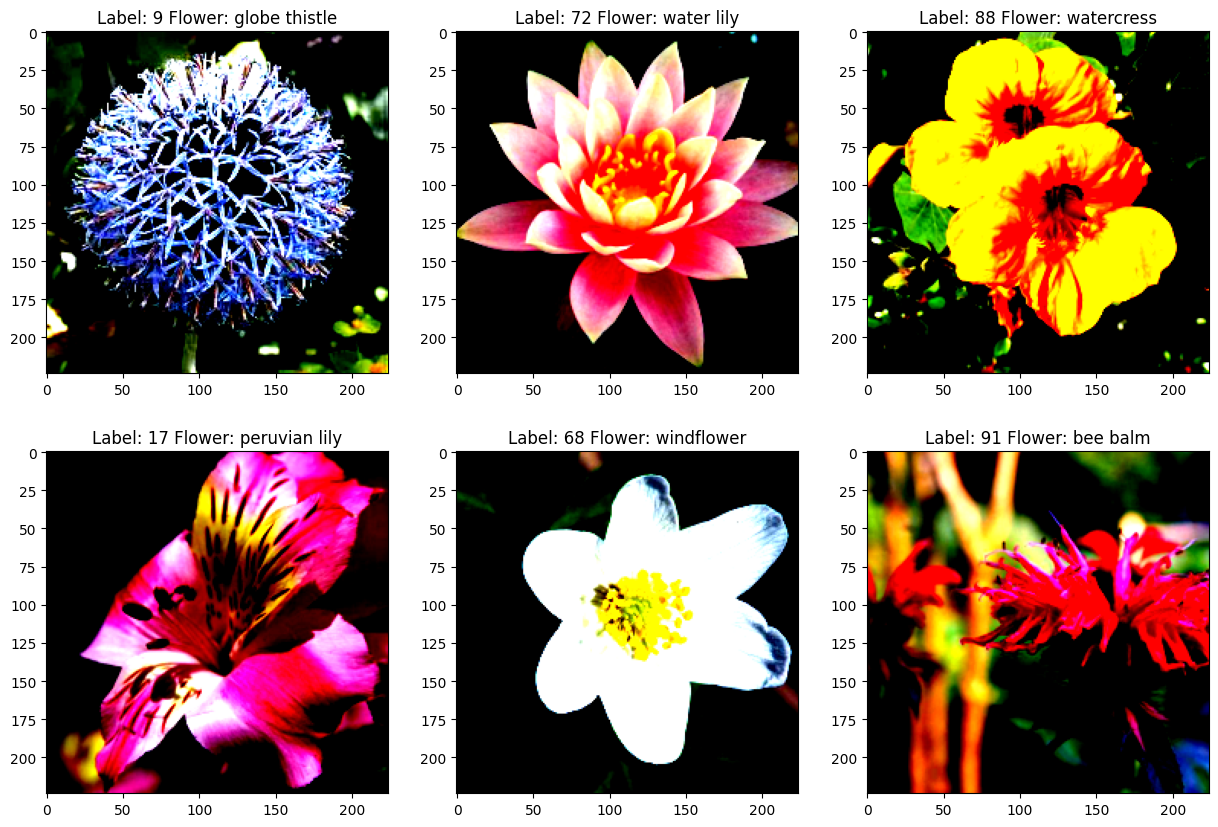

In [3]:
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 2

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(val_data), size=(1,)).item()
    img, label = val_data[sample_idx]
    img = img.permute(1, 2, 0)
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(f'Label: {label} Flower: {flower_name(label, classes)}')
    ax.axis("on")
    ax.imshow(img.squeeze(), cmap="Accent")
plt.show()

# Creating Neural Network

In [4]:
class CNN(nn.Module):

  def __init__(self):
     super(CNN, self).__init__()

     self.conv1 = nn.Conv2d(3, 32 ,3 , 2, 1) #Stride of 2 to cover more image area
     self.relu1 = nn.ReLU()
     self.bn1 = nn.BatchNorm2d(32) #Normalise the data at conv1

     self.conv2 = nn.Conv2d(32, 64 ,3 , 2, 1) #Increase the input layers to 32 as they were outputs of layer 1
     self.relu2 = nn.ReLU()
     self.bn2 = nn.BatchNorm2d(64)

     self.conv3 = nn.Conv2d(64, 128 ,3 ,2 ,1)
     self.relu3 = nn.ReLU()
     self.bn3 = nn.BatchNorm2d(128)

     self.fc1 = nn.Linear(128 * 28 * 28, 1024)
     self.bn4 = nn.BatchNorm1d(1024) #Switch to 1d normalisation as its now a fully connected layer

     self.fc2 = nn.Linear(1024, 512)
     self.bn5 = nn.BatchNorm1d(512)

     self.fc3 = nn.Linear(512, 102) #102 as there is 102 output classes
     self.bn6 = nn.BatchNorm1d(102)

  def forward(self, x):
     x = F.relu(self.conv1(x)) #Pass through the first layer down to the 3rd
     x = self.bn1(x)

     x = F.relu(self.conv2(x))
     x = self.bn2(x)

     x = F.relu(self.conv3(x))
     x = self.bn3(x)

     x = x.view(x.size(0), -1)

     x = F.relu(self.fc1(x))
     x = self.bn4(x) #Once passed through apply activation of the fully connected
     x = F.relu(self.fc2(x))
     x = self.bn5(x)
     x = F.dropout(x, p = 0.5)
     x = self.fc3(x)

     return x

cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=102, bias=True)
  (bn6): BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True, track_

##Training and testing the CNN

In [5]:
optimiser = optim.SGD(cnn.parameters(), lr=0.001, momentum = 0.9)

In [6]:
criterion = nn.CrossEntropyLoss()

In [21]:
def cnn_train(dataloader, cnn, criterion, optimiser): #Training the data
    cnn.train()
    size = len(dataloader.dataset)
    for batch, (inputs, actual) in enumerate(dataloader):
        predictions = cnn(inputs)
        loss = criterion(predictions, actual) #Compares the loss between input vs output

        loss.backward() #Backpropagation
        optimiser.step()
        optimiser.zero_grad()

        if batch % 4 == 3:
          print(f"Loss: {loss.item():.5f} ")

def test(dataloader, cnn, criterion): #Testing the data
    cnn.eval()
    size = len(dataloader.dataset)
    test_loss = 0
    correct_val = 0
    with torch.no_grad():
        for inputs, actual in dataloader:
            predictions = cnn(inputs)
            correct_val += (predictions.argmax(1) == actual).sum().item() #Argmax outputs the prediction with the highest probability for it to be actual

    test_loss /= batch_size
    correct_val /= size
    print(f"-------------------------------\nResults \n-------------------------------\nTest Accuracy: {(100*correct_val):.1f}%\n-------------------------------\n")

In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    cnn_train(trainloader, cnn, criterion, optimiser) #Training on training set
    test(valloader, cnn, criterion) #Testing on validation set
print("Done!")